In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer

In [4]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
#from xgboost import XGBRegressor

In [5]:
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

In [7]:
train=pd.read_csv('D:/UCSD/2021spring/495/final/train.csv')
test=pd.read_csv('D:/UCSD/2021spring/495/final/test.csv')
test_ID = test['ID']

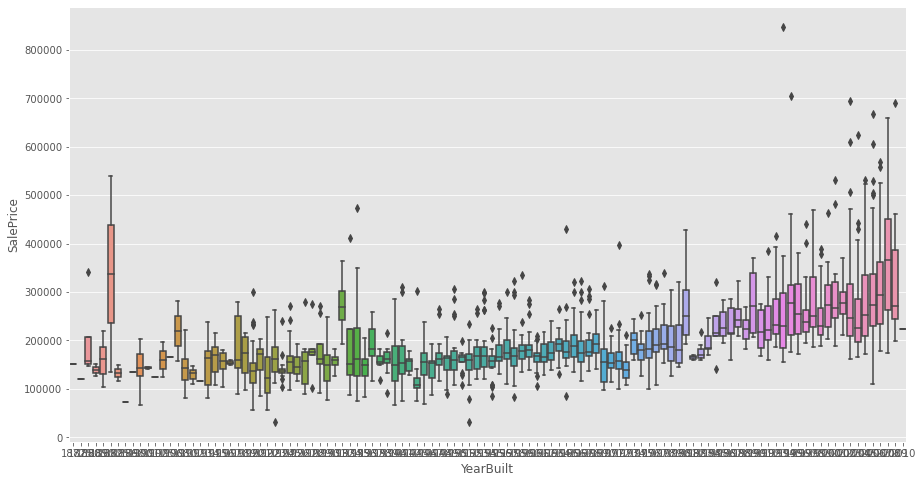

In [8]:
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

(0.0, 800000.0)

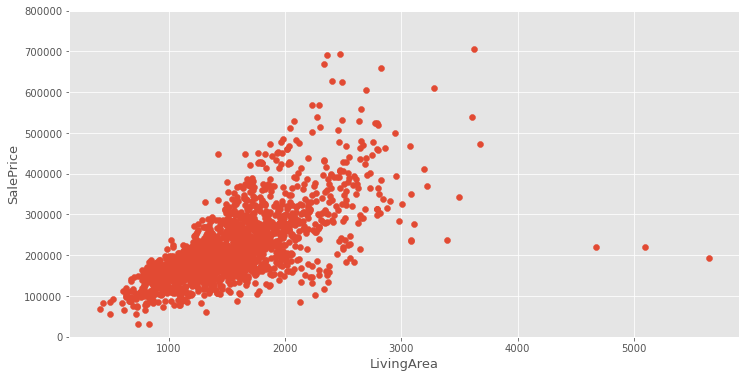

In [9]:
#check the exception points
plt.figure(figsize=(12,6))
plt.scatter(x=train.LivingArea, y=train.SalePrice)
plt.xlabel("LivingArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [10]:
#Drop the exception points
train.drop(train[(train["LivingArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

(0.0, 800000.0)

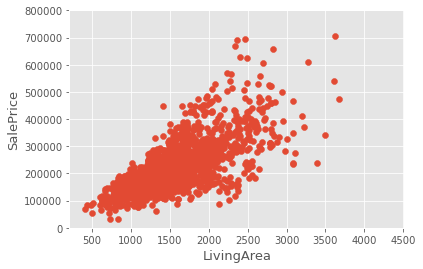

In [11]:
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['LivingArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LivingArea', fontsize=13)
plt.ylim(0,800000)



 mu = 215094.50 and sigma = 87583.43



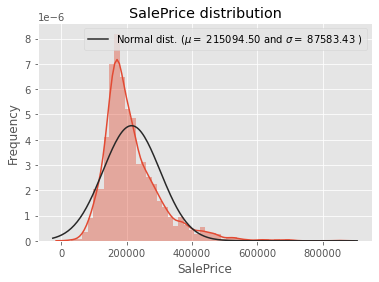

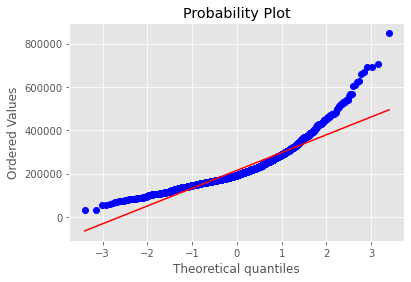

In [12]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()



 mu = 12.21 and sigma = 0.37



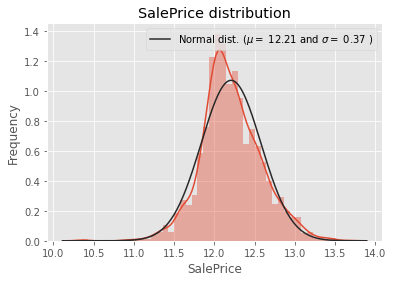

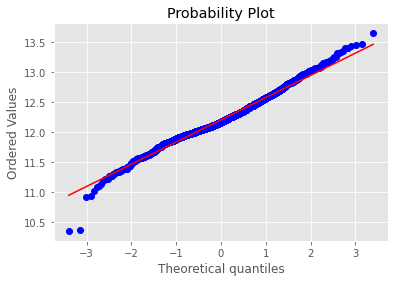

In [13]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2927, 80)


In [15]:
#Check the data missing ratio
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)


,Missing Ratio
PoolQuality,99.590024
Misc Feature,96.412709
TypeOfAlleyAccess,93.235395
FenceQuality,80.457807
FireplaceQuality,48.582166
LotFrontage,16.740690
GarageYearBuilt,5.432183
GarageCondition,5.432183
GarageFinish,5.432183
GarageQuality,5.432183


Text(0.5, 1.0, 'Percent missing data by feature')

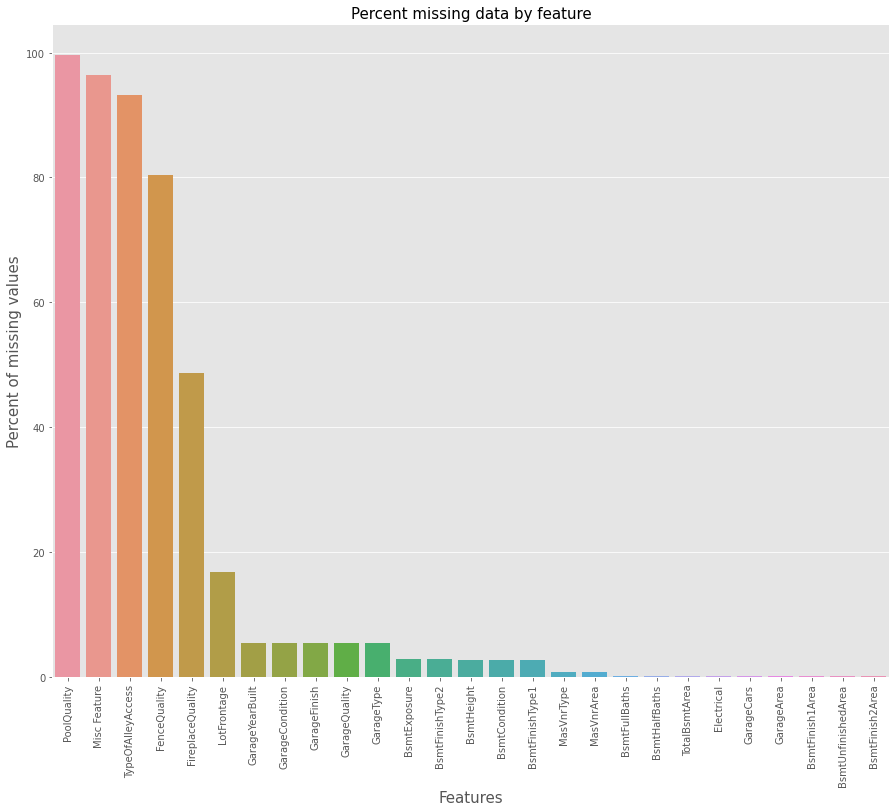

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


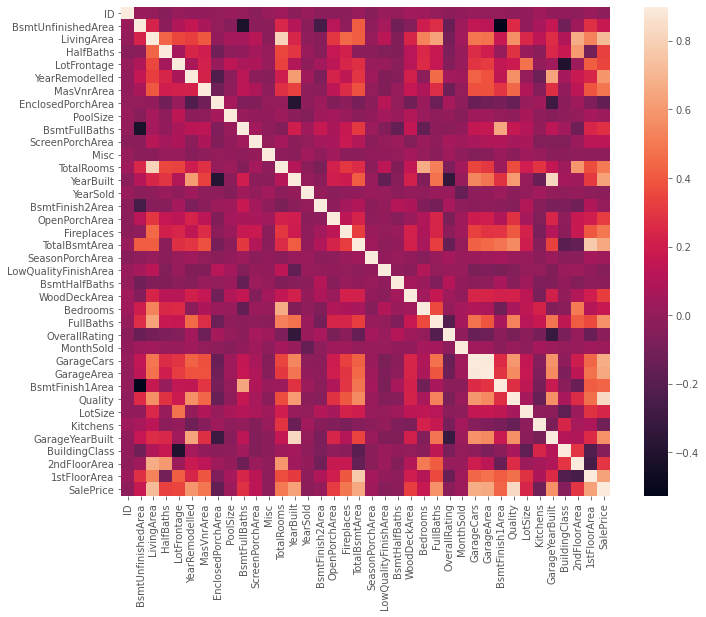

In [17]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)


In [18]:
#fill the missing data

all_data["PoolQuality"] = all_data["PoolQuality"].fillna("None")
all_data["Misc Feature"] = all_data["Misc Feature"].fillna("None")
all_data["TypeOfAlleyAccess"] = all_data["TypeOfAlleyAccess"].fillna("None")
all_data["FenceQuality"] = all_data["FenceQuality"].fillna("None")
all_data["FireplaceQuality"] = all_data["FireplaceQuality"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

#all_data["LotFrontage"] = all_data.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])
#all_data["LotAreaCut"] = pd.qcut(all_data.LotArea,10)

for col in ('GarageType', 'GarageFinish', 'GarageQuality', 'GarageCondition'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYearBuilt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinish1Area', 'BsmtFinish2Area', 'BsmtUnfinishedArea','TotalBsmtArea', 'BsmtFullBaths', 'BsmtHalfBaths'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtHeight', 'BsmtCondition', 'BsmtExposure', 'BsmtFinishType1', 'BsmtFinishType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [19]:
all_data.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])
all_data["LotFrontage"] = all_data["LotFrontage"].transform(lambda x: x.fillna(x.median()))
#all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [20]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()


,Missing Ratio


In [21]:
#Year and month sold are transformed into categorical features.
all_data['YearSold'] = all_data['YearSold'].astype(str)
all_data['MonthSold'] = all_data['MonthSold'].astype(str)


In [22]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQuality', 'BsmtHeight', 'BsmtCondition', 'GarageQuality', 'GarageCondition', 
        'ExteriorQual', 'ExteriorCond','HeatingQuality', 'PoolQuality', 'KitchenQuality', 'BsmtFinishType1', 
        'BsmtFinishType2', 'Functional', 'FenceQuality', 'BsmtExposure', 'GarageFinish', 'SlopeOfProperty',
        'Shape', 'Paved Drive', 'TypeOfAlleyAccess', 'Central Air',  'SaleCondition', 
        'YearSold', 'MonthSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2927, 80)


In [23]:
all_data['TotalSF'] = all_data['TotalBsmtArea'] + all_data['BsmtFinish1Area'] + all_data['BsmtFinish2Area']

In [24]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
Misc,22.221198
PoolSize,17.719247
LotSize,13.178732
LowQualityFinishArea,12.105635
SeasonPorchArea,11.391990
SlopeOfProperty,4.982762
Kitchens,4.309065
EnclosedPorchArea,4.010074
ScreenPorchArea,3.953057
BsmtHalfBaths,3.952498


In [25]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])


There are 60 skewed numerical features to Box Cox transform


In [26]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2927, 229)


In [27]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [28]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
#import lightgbm as lgb


In [29]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [30]:
#Build models
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [31]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


In [32]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


In [33]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1024 (0.0026)



In [34]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1022 (0.0026)



In [35]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Kernel Ridge score: 0.1033 (0.0045)



In [36]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [37]:
#use ENet,KKR, lasso
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Stacking Averaged models score: 0.1004 (0.0032)


In [38]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [39]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))


0.08721865537260304


In [40]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submission_final2.csv',index=False)